# **Siamese Network to find similarity between clothes in fashion_mnist dataset**

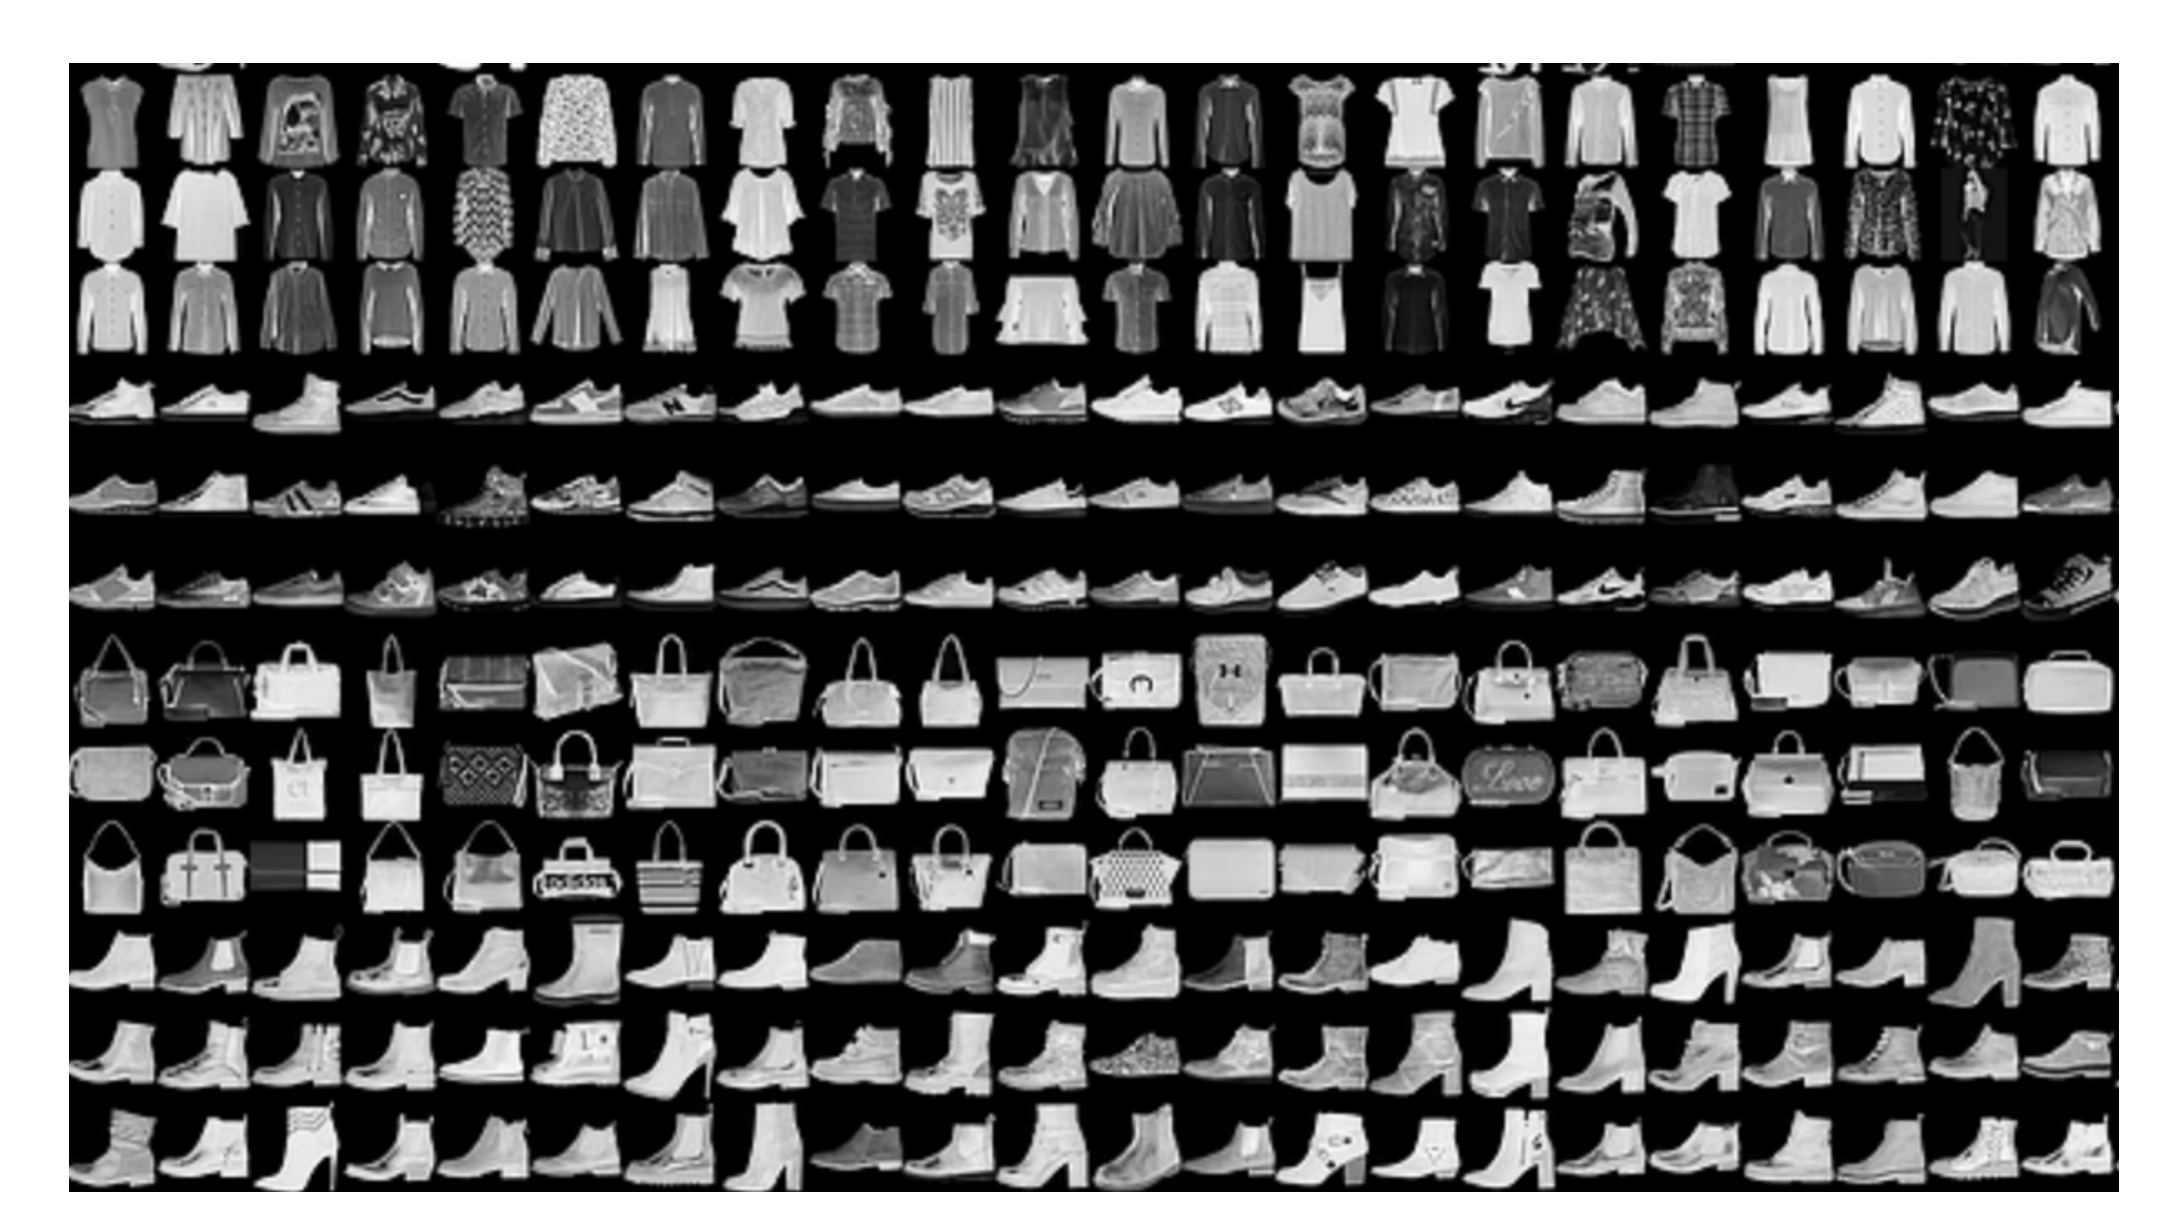

##***Importing Libraries***

In [ ]:
import tensorflow as tf
import tensorflow.keras as ks
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as k
import random

## ***functions to create similar and dissimilar pairs which we would use to train the siamese model***

In [ ]:
def create_pairs(x, digit_indices):
  pairs = []
  labels = []

  n = min([len(digit_indices[d]) for d in range(10)]) - 1

  for d in range(10):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]

      inc = random.randrange(1, 10)
      dn = (d+inc)%10

      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      
      labels += [1.0, 0.0]

  return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
  digit_indices = [np.where(labels==i)[0] for i in range(10)]
  # print(digit_indices)
  pairs, y = create_pairs(images, digit_indices)
  return pairs, y


def show_image(image):
  plt.figure()
  plt.imshow(image)
  plt.grid(False)
  plt.colorbar()
  plt.show()


In [ ]:
(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()

training_images = training_images.astype('float32')/255.0
test_images = test_images.astype('float32')/255.0


train_pairs, train_y = create_pairs_on_set(training_images, training_labels)
test_pairs, test_y = create_pairs_on_set(test_images, test_labels)

4423680/4422102 [==============================] - 0s 0us/step


## ***similar pairs are in the even pair and dissimilar are in the odd pairs***

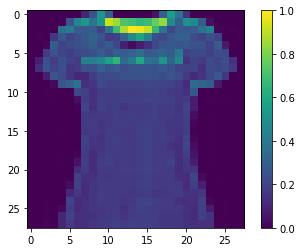

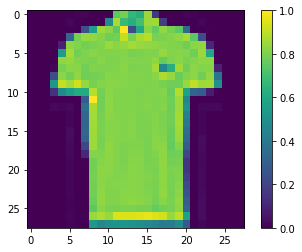

In [ ]:
pair = 8

show_image(test_pairs[pair][0])
show_image(test_pairs[pair][1])

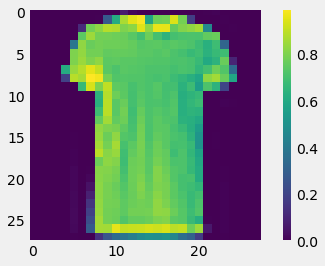

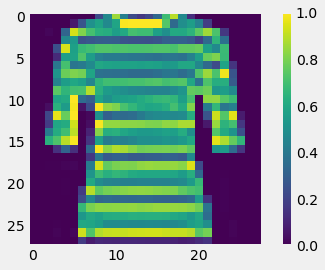

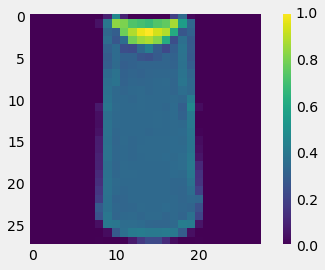

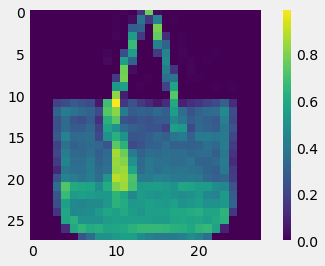

In [ ]:
show_image(train_pairs[8][0])
show_image(train_pairs[8][1])

show_image(train_pairs[3][0])
show_image(train_pairs[3][1])

## ***creating euclidean distance which would use in the lambda layer to get the output to find out the similarity***

In [ ]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = k.sum(k.square(x-y), axis=1, keepdims=True)
  return k.sqrt(k.maximum(sum_square, k.epsilon()))

def eucl_dist_output_shapes(shape):
  shape1, shape2 = shape
  return (shape1[0], 1)


## ***Creating our base model***

In [ ]:
def initialize_base_network():
  input_ = Input(shape=(28, 28, ), name='input_layer')
  x = Flatten(name='flatten')(input_)
  x = Dense(128, activation='relu', name='Dense_1')(x)
  x = Dropout(0.1, name='dropout_1')(x)
  x = Dense(128, activation='relu', name='Dense_2')(x)
  x = Dropout(0.1, name='dropout_2')(x)
  x = Dense(128, activation='relu', name='Dense_3')(x)

  return Model(inputs=input_, outputs=x)

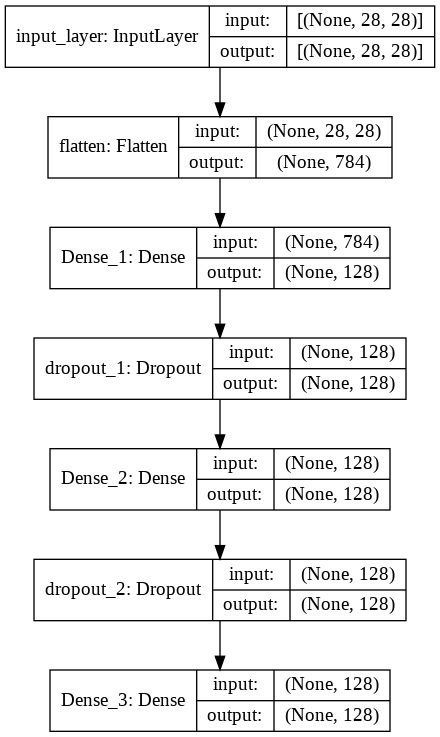

In [ ]:
base_network = initialize_base_network()

ks.utils.plot_model(base_network, show_shapes=True, show_layer_names=True)

## ***creating the siamese network model***

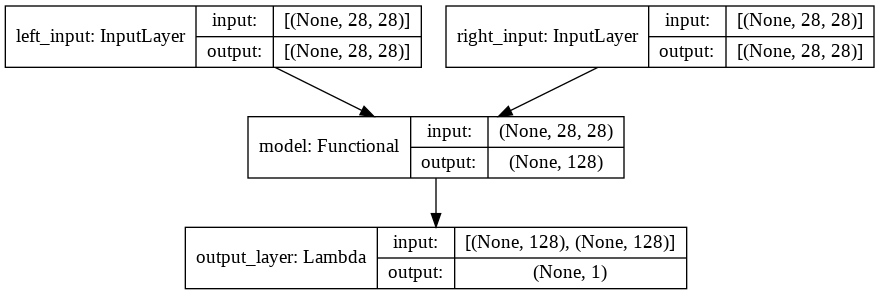

In [ ]:
input_a = Input(shape=(28, 28, ), name='left_input')
vect_output_a = base_network(input_a)

input_b = Input(shape=(28, 28,), name='right_input')
vect_output_b = base_network(input_b)

output = Lambda(euclidean_distance, name='output_layer', output_shape=eucl_dist_output_shapes)([vect_output_a, vect_output_b])

model = Model(inputs=[input_a, input_b], outputs=output)

ks.utils.plot_model(model, show_shapes=True, show_layer_names=True)

## ***using a custom loss called contrstive loss***

In [ ]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_preds):
    square_preds = k.square(y_preds)
    margin_square = k.square(k.maximum(margin-y_preds, 0))
    return k.mean(y_true*square_preds + (1-y_true)*margin_square)
  return contrastive_loss

In [ ]:
model.compile(optimizer=ks.optimizers.RMSprop(), loss=contrastive_loss_with_margin(margin=1))

history = model.fit(x=[train_pairs[:,0], train_pairs[:,1]],
                    y=train_y,
                    epochs=50, batch_size=128, 
                    validation_data=([test_pairs[:,0], test_pairs[:,1]], test_y))

Epoch 1/50
938/938 [==============================] - 7s 4ms/step - loss: 0.1480 - val_loss: 0.0826
Epoch 2/50
938/938 [==============================] - 3s 3ms/step - loss: 0.0821 - val_loss: 0.0752
Epoch 3/50
938/938 [==============================] - 3s 3ms/step - loss: 0.0726 - val_loss: 0.0716
Epoch 4/50
938/938 [==============================] - 3s 3ms/step - loss: 0.0667 - val_loss: 0.0705
Epoch 5/50
938/938 [==============================] - 3s 3ms/step - loss: 0.0630 - val_loss: 0.0659
Epoch 6/50
938/938 [==============================] - 3s 3ms/step - loss: 0.0606 - val_loss: 0.0663
Epoch 7/50
938/938 [==============================] - 3s 3ms/step - loss: 0.0594 - val_loss: 0.0644
Epoch 8/50
938/938 [==============================] - 3s 3ms/step - loss: 0.0577 - val_loss: 0.0652
Epoch 9/50
938/938 [==============================] - 3s 3ms/step - loss: 0.0569 - val_loss: 0.0646
Epoch 10/50
938/938 [==============================] - 3s 3ms/step - loss: 0.0558 - val_loss: 0.0659

## ***lets Visualize how good the siamese model predicts***

In [ ]:
def compute_accuracy(y_true, y_pred):
  pred = y_pred.ravel()<0.5
  return np.mean(pred == y_true)

In [ ]:
loss = model.evaluate(x=[test_pairs[:, 0], test_pairs[:, 1]],y=test_y)
print(f'Loss = {loss}')

625/625 [==============================] - 1s 2ms/step - loss: 0.0664
Loss = 0.06644890457391739


In [ ]:
train_preds = model.predict([train_pairs[:, 0], train_pairs[:, 1]])
train_accuracy = compute_accuracy(train_y, train_preds)

test_preds = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
test_accuracy = compute_accuracy(test_y, test_preds)

print(f'Training Accuracy = {train_accuracy}\nTesting_accuracy = {test_accuracy}')

Training Accuracy = 0.9498166361060176
Testing_accuracy = 0.9106106106106107


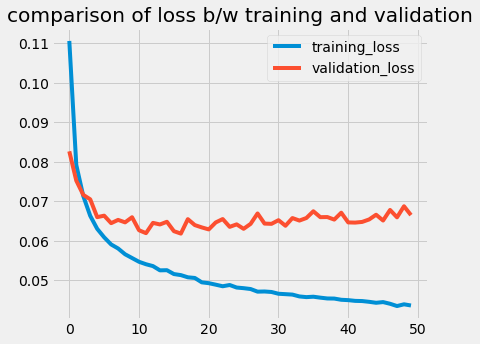

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(6, 5))
epochs = len(history.history['loss'])
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='training_loss')
plt.plot(val_loss, label='validation_loss')
plt.legend()
plt.title('comparison of loss b/w training and validation')
plt.show()

In [ ]:
def display_images(left, right, prediction, label, title, n):
  plt.figure(figsize=(25, 7))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  plt.grid(None)
  
  left = np.reshape(left, [n, 28, 28])
  left = np.swapaxes(left, 0, 1)
  left = np.reshape(left, [28, 28*n])
  plt.imshow(left)
  plt.figure(figsize=(25, 7))
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], prediction)

  for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if prediction[i]>0.5:
      t.set_color('red')
  plt.grid(None)
  right = np.reshape(right, [n,28, 28])
  right = np.swapaxes(right, 0, 1)
  right = np.reshape(right, [28, 28*n])
  plt.imshow(right)

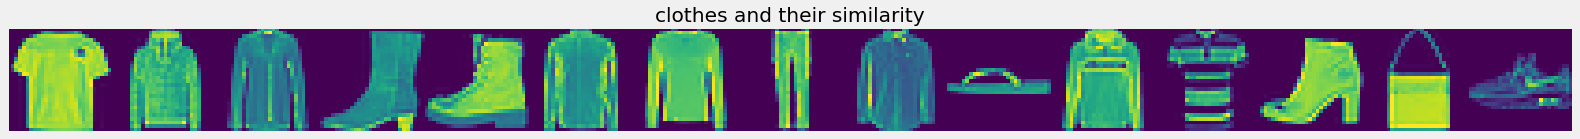

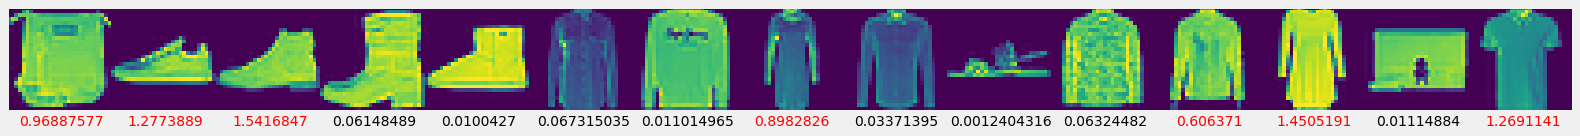

In [ ]:
y_preds = np.squeeze(train_preds)
indexes = np.random.choice(len(y_preds), size=15)

display_images(train_pairs[:, 0][indexes], train_pairs[:, 1][indexes], y_preds[indexes], train_y[indexes], 'clothes and their similarity', 15)